In [3]:
import json
import os
from datetime import datetime
from collections import *
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser
from transformers import BertTokenizer,BertForSequenceClassification, BertConfig, AdamW
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import csv
import sys
sys.path.append('/home/kalkiek/projects/reddit-political-affiliation/')
from src.features.interactions.political_comment import PoliticalComment
import matplotlib.pyplot as plt
import praw
from status_count import client_id, client_secret, user_agent

In [5]:
def read_in_bad_actors_from_tsv(in_files):
    bad_actors = defaultdict(list)

    for in_file in in_files:
        print("Reading in user politics from file: {}".format(in_file))
        with open(in_file, 'r',encoding="utf-8") as f:
            for line in f:
                if len(line)>1:
                    #print(line.split("\t"))
                    #user, politics, regex_match, pt,subreddit, created, text = line.split('\t')
                    #Eentry = {'politics': politics, 'regex_match': regex_match, 'subreddit': subreddit,'created': created, 'text': text}
                    user, politics,source, subreddit,created= line.split('\t')
                    if 1: #source=='gold' or source=='flair':
                        entry = {'politics': politics, 'regex_match': "", 'subreddit': subreddit,
                                 'created': created,
                                 'text': ""}
                        #print(entry)
                        bad_actors[user].append(entry)

    return bad_actors

In [4]:
# need reddit praw client id and secret. Researchs' id and secret are hidden
reddit = praw.Reddit(
    client_id=client_id,
     client_secret=client_secret,
     user_agent=user_agent
 )

In [6]:
# read in bad actors
bad_dir='/shared/0/projects/reddit-political-affiliation/data/bad-actors/'
comments_dir=bad_dir+'comments/'
bad_actors = read_in_bad_actors_from_tsv([bad_dir+'bad_actors_90_days_1_flip_flop.tsv'])
print("# of bad actors: {}".format(len(bad_actors)))

Reading in user politics from file: /shared/0/projects/reddit-political-affiliation/data/bad-actors/bad_actors_90_days_1_flip_flop.tsv
# of bad actors: 5538


In [9]:
# build bad actors dataframe
rows=[]
for key in bad_actors.keys():
    user=bad_actors[key]
    for one in user:
        rows.append((key,one['politics'],one['created']))
df = pd.DataFrame(rows, columns =['username', 'politics', 'created'])
df.sort_values(by=['username','created'],inplace=True)
df.reset_index(inplace=True,drop=True)

In [10]:
# count flips by month
old_username='-I_Have_No_Idea-'
old_politics='Republican'
flip_year=Counter()
fliped=False
for idx,row in df.iterrows():
    new_username=row['username']
    new_politics=row['politics']
    if new_username==old_username:
        if not fliped:
            if new_politics!=old_politics:
                first_pol_post_ts = int(row['created'])
                first_post_date = datetime.fromtimestamp(first_pol_post_ts)
                year_month = str(first_post_date.year) + '-' + str(first_post_date.month)
                flip_year[year_month]+=1
                #print(idx,new_username,year_month)
                fliped=True
    else:
        old_username=new_username
        old_politics=new_politics
        fliped=False   
print(flip_year)

Counter({'2016-11': 278, '2017-1': 256, '2016-12': 193, '2016-10': 165, '2017-2': 163, '2017-3': 139, '2016-7': 137, '2019-9': 125, '2018-7': 125, '2016-8': 124, '2016-9': 121, '2016-3': 117, '2017-5': 111, '2018-6': 107, '2017-8': 103, '2018-10': 102, '2019-10': 102, '2017-4': 102, '2017-7': 101, '2017-12': 100, '2016-5': 99, '2016-4': 95, '2017-10': 94, '2019-1': 91, '2019-6': 90, '2018-8': 90, '2016-6': 90, '2019-7': 90, '2018-11': 89, '2017-9': 89, '2019-4': 88, '2017-6': 88, '2018-9': 86, '2018-1': 86, '2019-8': 84, '2019-11': 80, '2017-11': 79, '2016-2': 78, '2019-12': 78, '2019-5': 78, '2018-3': 78, '2018-2': 75, '2018-4': 73, '2018-5': 70, '2019-3': 64, '2018-12': 62, '2019-2': 51, '2016-1': 46, '2015-12': 26, '2015-11': 20, '2012-11': 19, '2015-9': 19, '2012-8': 19, '2012-10': 18, '2015-7': 15, '2015-8': 15, '2015-3': 12, '2012-9': 11, '2015-10': 11, '2012-7': 10, '2014-11': 10, '2015-5': 9, '2011-8': 9, '2013-10': 9, '2013-1': 9, '2011-12': 8, '2015-6': 8, '2014-4': 8, '2012-

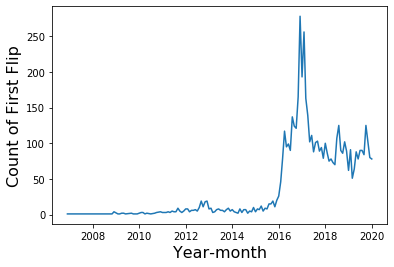

In [11]:
# plot flip changes over time
rows = []
for year_month, count in dict(flip_year).items():
    row = {'Year Month': parser.parse(year_month), 'Count': int(count)}
    rows.append(row)
    
#plt.figure(figsize=(8,6))
flip_time = pd.DataFrame(rows)#flip_time
plt.xlabel('Year-month', fontsize=16)
plt.ylabel('Count of First Flip', fontsize=16)
sns.lineplot(data=flip_time, x='Year Month', y='Count')
plt.savefig('bad_actors_flip_counts/plots/flip_time.pdf', dpi=300,facecolor='w',bbox_inches='tight')

In [19]:
# count bad actors in each subreddit
poli_counter=Counter()
for key in bad_actors:
    information=bad_actors[key]
    for one_sent in information:
        poli_counter[one_sent['subreddit']]+=1

In [20]:
poli_df=pd.DataFrame(
    {'subreddit':list(poli_counter.keys()),
     'count':list(poli_counter.values())
    })
poli_df['log_count']=poli_df['count'].apply(np.log)

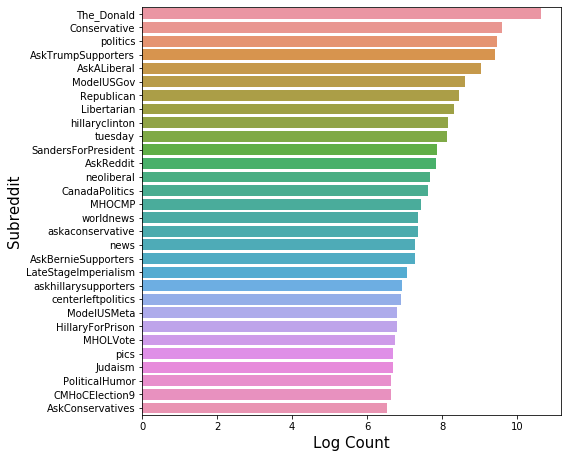

In [21]:
# plot log count of subreddits with most bad actors
plt.figure(figsize=(7.5, 7.5))
sns.barplot(x="log_count", y="subreddit", data=poli_df.sort_values(by=['log_count'],ascending=False)[:30])
plt.xlabel('Log Count', fontsize=15)
plt.ylabel('Subreddit', fontsize=15)
plt.savefig('bad_actors_flip_counts/plots/wherebadactorspost_90_log.pdf', dpi=300,facecolor='w',bbox_inches='tight')

In [23]:
# check status of users {banned, deleted, suspended}
def check_status_of_user_list(very_divided_list):
    suspended_user_list=[]
    deleted_user_list=[]
    alive_user_list=[]
    indicate_list=[]
    for actor in very_divided_list:
        try:
            redditor = reddit.redditor(actor)
            if redditor.is_suspended:
                #print("Actor",actor,"is suspended")
                suspended_user_list.append(actor)
                indicate_list.append(0)
        except:
            try:
                for comment in redditor.comments.new(limit=1):
                    a=1
                alive_user_list.append(actor)
                indicate_list.append(2)
                #print("Actor,",actor,"is alive")
            except:
                #print("Actor",actor,"is deleted")
                deleted_user_list.append(actor)
                indicate_list.append(1)
    return suspended_user_list,deleted_user_list,alive_user_list,indicate_list

In [24]:
sa,da,aa,ia=check_status_of_user_list(all_actor)
print("Bad Actors Overall suspended:",len(sa),", Deleted:",len(da),",Alive:",len(aa))

In [52]:
cong_dir='/shared/0/projects/reddit-political-affiliation/data/conglomerate-affiliations/'
dev_cong=pd.read_csv(cong_dir+'dev.tsv',sep='\t')
dev_cong=dev_cong[dev_cong['source']!='community']
sd,dd,ad,ide=check_status_of_user_list(dev_cong['username'])
print("Political Users Overall suspended:",len(sd),", Deleted:",len(dd),",Alive:",len(ad))